In [1]:
import sys

sys.path.insert(0, "..")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm

# Our modules
from src.agents.dqn_agent import DQNAgent
from src.mdp import RewardFunction
from src.agents.callbacks.learning_curve_callback import LearningCurveCallback
from src.agents.metrics import TrainingMetrics, EvaluationMetrics
from src.seeds import generate_seeds

# Plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 4)

## 2. Environment Setup

In [2]:
# Configuration
EPISODE_LENGTH = 1000  # days

TRAINING_SEED = generate_seeds(1, start_index=20)[0]
EVAL_SEED = generate_seeds(1, start_index=21)[0]
EVAL_SEEDS = generate_seeds(100, start_index=100)

print("🎲 DQN Training Seeds:")
print(f"   Training: {TRAINING_SEED}")
print(f"   Validation: {EVAL_SEED}")
print(f"   Final evaluation: {len(EVAL_SEEDS)} seeds starting at {EVAL_SEEDS[0]}")

🎲 DQN Training Seeds:
   Training: 6173
   Validation: 29
   Final evaluation: 100 seeds starting at 2216


In [3]:
from src.environment.gym_env import InventoryEnvironment


def make_env(
    episode_length: int = EPISODE_LENGTH,
    random_seed: int = TRAINING_SEED,
) -> InventoryEnvironment:
    return InventoryEnvironment(
        k=30,
        Q_max=30,
        episode_length=episode_length,
        random_seed=random_seed,
    )


env = make_env(random_seed=TRAINING_SEED)
print(env)

Inventory Management Gym Environment (k=30, Q_max=30, episode_length=1000)


## 3. Create and Train DQN Agent

In [4]:
agent = DQNAgent(
    env=env,
    learning_rate=1e-4,
    gamma=0.99,
    buffer_size=100_000,
    batch_size=64,
    exploration_fraction=0.3,
    exploration_final_eps=0.05,
    target_update_interval=1000,
    learning_starts=1000,
    train_freq=2,
    tensorboard_log=None,
    policy_kwargs=dict(net_arch=[256, 256]),
    seed=TRAINING_SEED,
    verbose=0,
)

print(f"DQN Agent created with seed {TRAINING_SEED}")

DQN Agent created with seed 6173


## 5. Training

Train the DQN agent with periodic evaluation.

**Monitor with TensorBoard:**
```bash
tensorboard --logdir=./logs
```

In [5]:
TOTAL_TIMESTEPS = 3_000_000

print(f"🚀 Starting training for {TOTAL_TIMESTEPS:,} timesteps...")
print(f"   ≈ {TOTAL_TIMESTEPS // EPISODE_LENGTH:,} episodes\n")

# Initialize plot classes
training_plots = TrainingMetrics()
evaluation_plots = EvaluationMetrics()

# Callbacks
learning_curve_callback = LearningCurveCallback()

agent.train(
    total_timesteps=TOTAL_TIMESTEPS,
    progress_bar=True,
    callbacks=learning_curve_callback,
)

print(f"\nTraining complete!")
print(f"  Episodes recorded: {len(learning_curve_callback.episode_rewards)}")

Output()

🚀 Starting training for 3,000,000 timesteps...
   ≈ 3,000 episodes




Training complete!
  Episodes recorded: 3000


## 6. Save the Trained Model

In [6]:
agent.save()

DQN weights saved to models


---
# Phase 1: Training Analysis


### 1. Learning Curve (Training Stability)
Average Reward per Episode vs. Timesteps with baseline comparison.


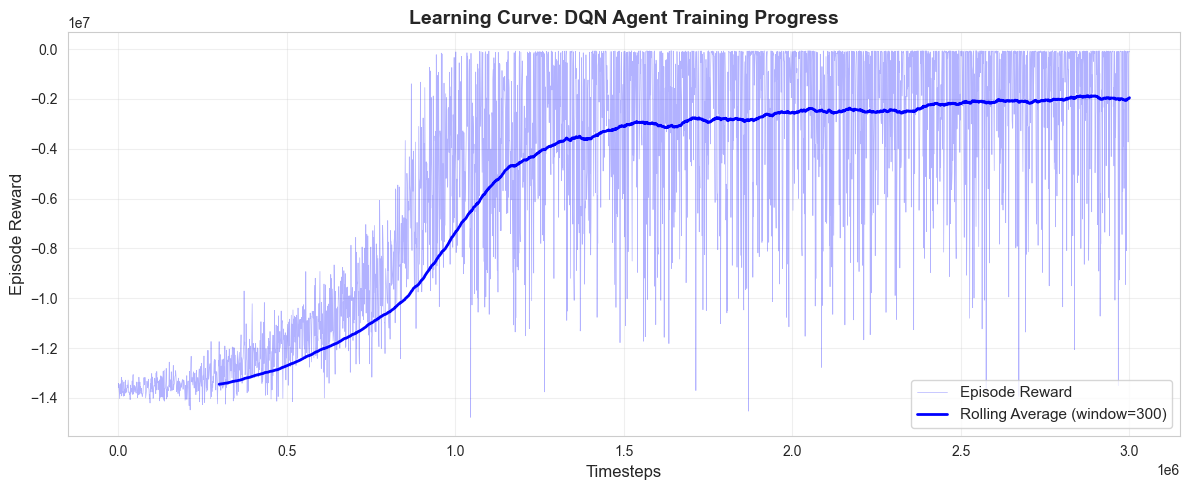

📊 Training Statistics:
  Total Episodes: 3000
  Total Timesteps: 3000000
  Episode Length: 1000.00 timesteps

  -- Performance (Last 300 episodes) --
  Mean Reward:   -1950511.75 ± 2776830.00
  Min Reward:    -13500366.00
  Max Reward:    -66220.00

  -- Specifics --
  Best Ever Reward: -63433.00
  Last Ep Reward:   -101020.00

 -- Daily Rewards --
  Mean Reward per Day: -5407.65 ± 4957.97
  Final Mean Reward per Day (last 300 eps): -1950.51 ± 2776.83


In [16]:
window = int(0.1 * (TOTAL_TIMESTEPS // EPISODE_LENGTH))

# Learning Curve: Use data from callback
training_plots.plot_learning_curve(
    episode_timesteps=learning_curve_callback.episode_timesteps,
    episode_rewards=learning_curve_callback.episode_rewards,
    window=max(window, 5),
    title="Learning Curve: DQN Agent Training Progress",
)

### 2. Exploration vs Exploitation
Epsilon decay over training timesteps.


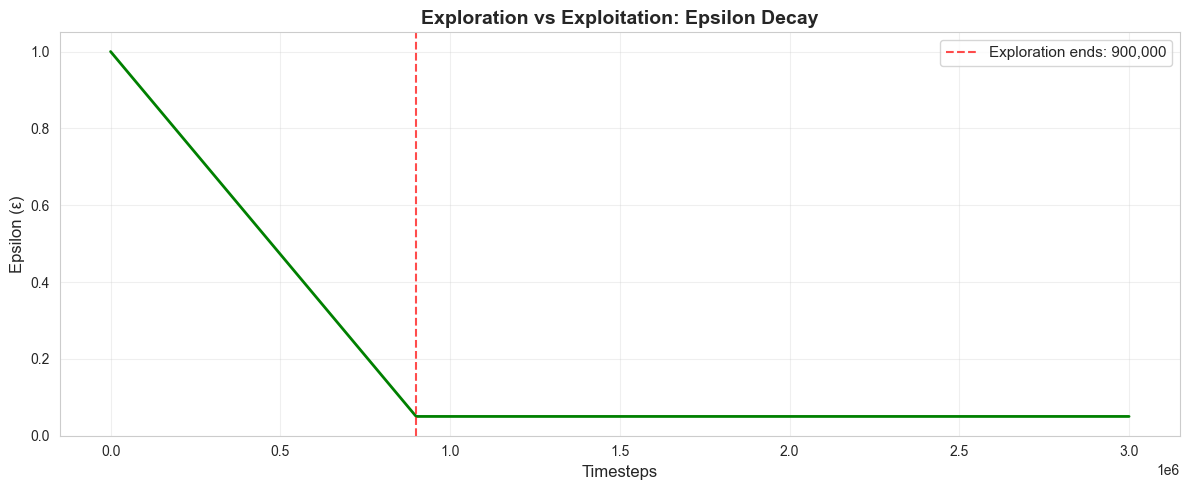

In [8]:
training_plots.plot_epsilon_decay(
    total_timesteps=TOTAL_TIMESTEPS,
    exploration_fraction=agent.hyperparams["exploration_fraction"],
    exploration_final_eps=agent.hyperparams["exploration_final_eps"],
    title="Exploration vs Exploitation: Epsilon Decay",
)

---
# Phase 2: Evaluation & Testing
Run N=100 independent test episodes with deterministic policy (ε=0).


In [9]:
N_TEST_EPISODES = len(EVAL_SEEDS)

reward_fn = RewardFunction()
test_episodes_dqn = []

print(f"🧪 Running {N_TEST_EPISODES} test episodes with deterministic seeds...")

for ep, seed in tqdm(
    enumerate(EVAL_SEEDS), total=N_TEST_EPISODES, desc="Evaluating DQN"
):
    dqn_env = make_env(random_seed=seed)
    obs, _ = dqn_env.reset()

    dqn_data = {
        "net_inv_0": [],
        "net_inv_1": [],
        "q0": [],
        "q1": [],
        "demand_0": [],
        "demand_1": [],  # Daily demand per product
        "ordering_cost": [],
        "holding_cost": [],
        "shortage_cost": [],
        "total_daily_cost": [],
    }

    done = False
    while not done:
        action = agent.select_action(obs, deterministic=True)
        action_obj = dqn_env.action_space_config.get_action(action)
        obs, reward, terminated, truncated, info = dqn_env.step(action)

        # Log Inventory & Actions
        dqn_data["net_inv_0"].append(info["net_inventory"][0])
        dqn_data["net_inv_1"].append(info["net_inventory"][1])
        dqn_data["q0"].append(action_obj.order_quantities[0])
        dqn_data["q1"].append(action_obj.order_quantities[1])

        # Log Daily Demand per product
        dqn_data["demand_0"].append(info["total_demand"][0])
        dqn_data["demand_1"].append(info["total_demand"][1])

        # Compute Daily Cost Components using RewardFunction
        state = dqn_env.get_current_state()
        costs = reward_fn.calculate_costs(state, action_obj)

        # Append to lists
        dqn_data["ordering_cost"].append(costs.ordering_cost)
        dqn_data["holding_cost"].append(costs.holding_cost)
        dqn_data["shortage_cost"].append(costs.shortage_cost)
        dqn_data["total_daily_cost"].append(costs.total_cost)

        done = terminated or truncated

    test_episodes_dqn.append(dqn_data)

print(f"Collected {N_TEST_EPISODES} test episodes for DQN")

🧪 Running 100 test episodes with deterministic seeds...


Evaluating DQN:   0%|          | 0/100 [00:00<?, ?it/s]

Collected 100 test episodes for DQN


### Warm-up Period Analysis (Welch's Graphical Procedure)
Since the simulation starts with initial inventory conditions, the early data may be biased (transient phase).   
We use Welch's procedure to identify when steady-state begins.

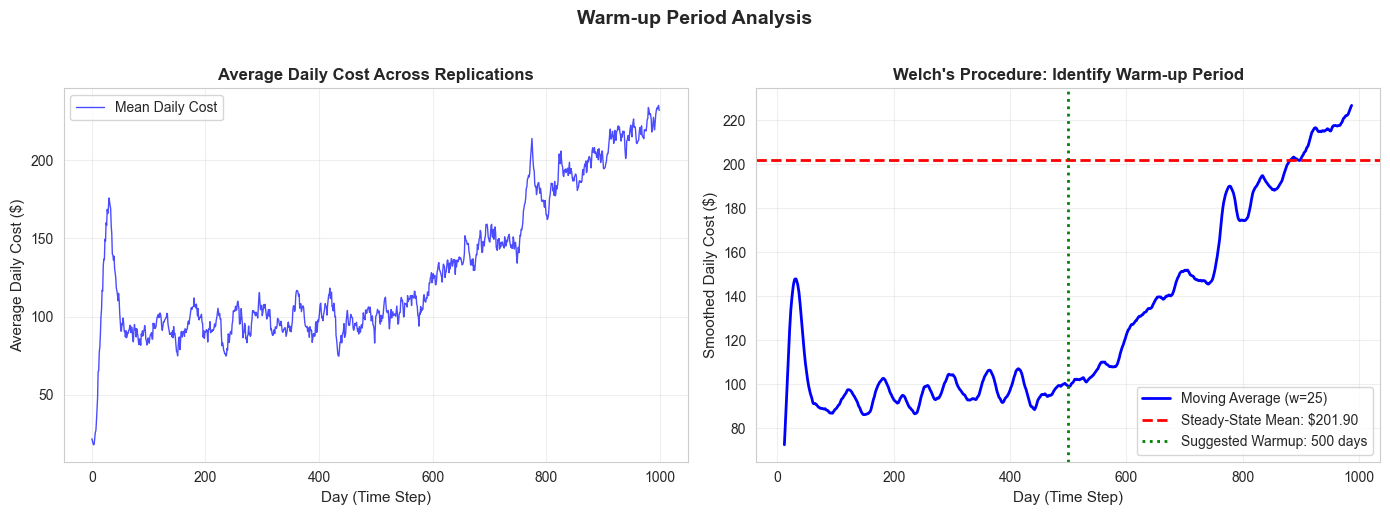

📊 Welch's Procedure Summary:
   Total replications: 100

✅ Suggested Warmup Length: 500 days
   (Detected where curve stays within 5% of steady-state)

💡 Tip: Visually verify the green line on the right plot.
   Adjust manually if needed based on your domain knowledge.


In [10]:
# Welch's Graphical Procedure for Warm-up Detection
n_days, n_reps, WARMUP_LENGTH = evaluation_plots.plot_welch_procedure(
    test_episodes=test_episodes_dqn,
    window_size=25,
    title="Warm-up Period Analysis",
)

In [11]:
print(f"   Steady-state analysis will use days {WARMUP_LENGTH+1} to {n_days}")
print(f"   Effective data per episode: {n_days - WARMUP_LENGTH} days")

   Steady-state analysis will use days 501 to 1000
   Effective data per episode: 500 days


In [17]:
print("\n📊 Computing final evaluation statistics...")

all_daily_costs = np.concatenate(
    [ep["total_daily_cost"][WARMUP_LENGTH:] for ep in test_episodes_dqn]
)
episode_totals = np.array(
    [sum(ep["total_daily_cost"][WARMUP_LENGTH:]) for ep in test_episodes_dqn]
)

d0_total = sum(sum(ep["demand_0"][WARMUP_LENGTH:]) for ep in test_episodes_dqn)
d1_total = sum(sum(ep["demand_1"][WARMUP_LENGTH:]) for ep in test_episodes_dqn)
total_customers = d0_total + d1_total
num_episodes = len(test_episodes_dqn)

# --- 2. Statistics Calculation ---
stats = {
    "daily_mean": np.mean(all_daily_costs),
    "daily_std": np.std(all_daily_costs, ddof=1),
    "total_mean": np.mean(episode_totals),
    "total_std": np.std(episode_totals, ddof=1),
}

# Confidence Intervals (95%)
stats["daily_ci"] = 1.96 * stats["daily_std"] / np.sqrt(all_daily_costs.size)
stats["total_ci"] = 1.96 * stats["total_std"] / np.sqrt(num_episodes)


# --- 3. Optimized Printing ---
def print_header(title):
    print(f"\n{'='*60}")
    print(f"{title:^60}")
    print(f"{'='*60}")


print_header("RESULTS - DAILY COST METRICS")
print(f"  Mean Cost      : ${stats['daily_mean']:>10.2f} / day")
print(f"  Std Deviation  : ${stats['daily_std']:>10.2f}")
print(f"  95% Conf. Int. : ±${stats['daily_ci']:>9.2f}")

print_header("RESULTS - EPISODE METRICS")
print(f"  Mean Cost      : ${stats['total_mean']:>10.2f} / episode")
print(f"  Std Deviation  : ${stats['total_std']:>10.2f}")
print(f"  95% Conf. Int. : ±${stats['total_ci']:>9.2f}")


📊 Computing final evaluation statistics...

                RESULTS - DAILY COST METRICS                
  Mean Cost      : $    163.01 / day
  Std Deviation  : $    778.04
  95% Conf. Int. : ±$     6.82

                 RESULTS - EPISODE METRICS                  
  Mean Cost      : $  81505.47 / episode
  Std Deviation  : $ 336062.78
  95% Conf. Int. : ±$ 65868.30


### 3. Cost Component Breakdown (Economic Analysis)
Grouped bar chart
 decomposed into Ordering, Holding, and Shortage costs.

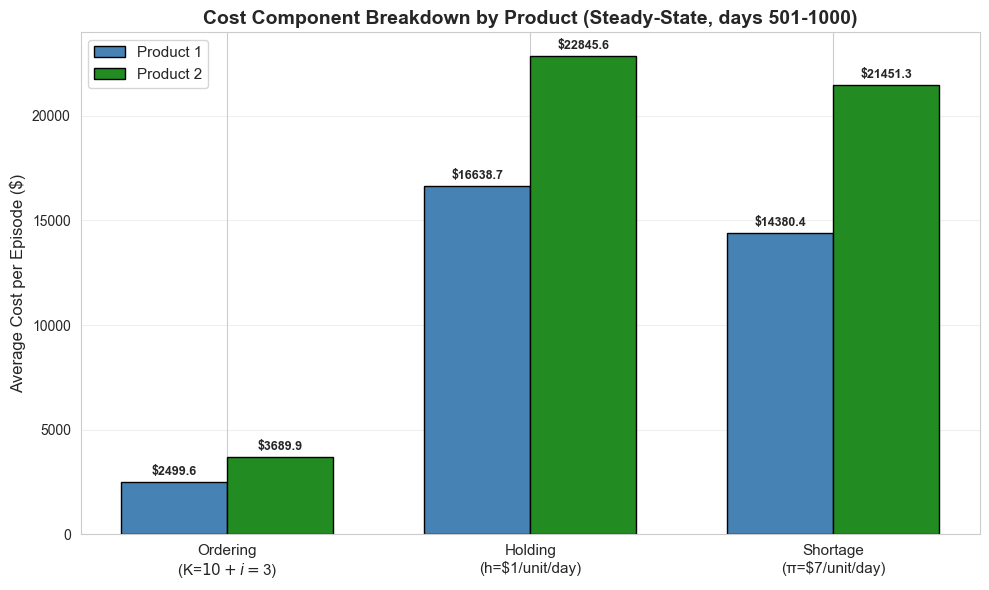

📊 Steady-State Average Cost per Episode (days 501-1000):

  Product 1: $33518.61
    Ordering: $2499.56 (7.5%)
    Holding:  $16638.67 (49.6%)
    Shortage: $14380.38 (42.9%)

  Product 2: $47986.86
    Ordering: $3689.94 (7.7%)
    Holding:  $22845.63 (47.6%)
    Shortage: $21451.29 (44.7%)

------------------------------------------------------------

  TOTAL: $81505.47


In [13]:
evaluation_plots.plot_cost_breakdown_by_product(
    test_episodes=test_episodes_dqn,
    warmup_length=WARMUP_LENGTH,
    n_days=n_days,
    title="Cost Component Breakdown by Product",
)

### 4. Operational Time Series (Behavioral Analysis)
Snapshot of inventory levels, orders, and demand over time for selected episodes.


📊 Representative episode: 79 (avg cost: 117.02, global mean: 129.73)


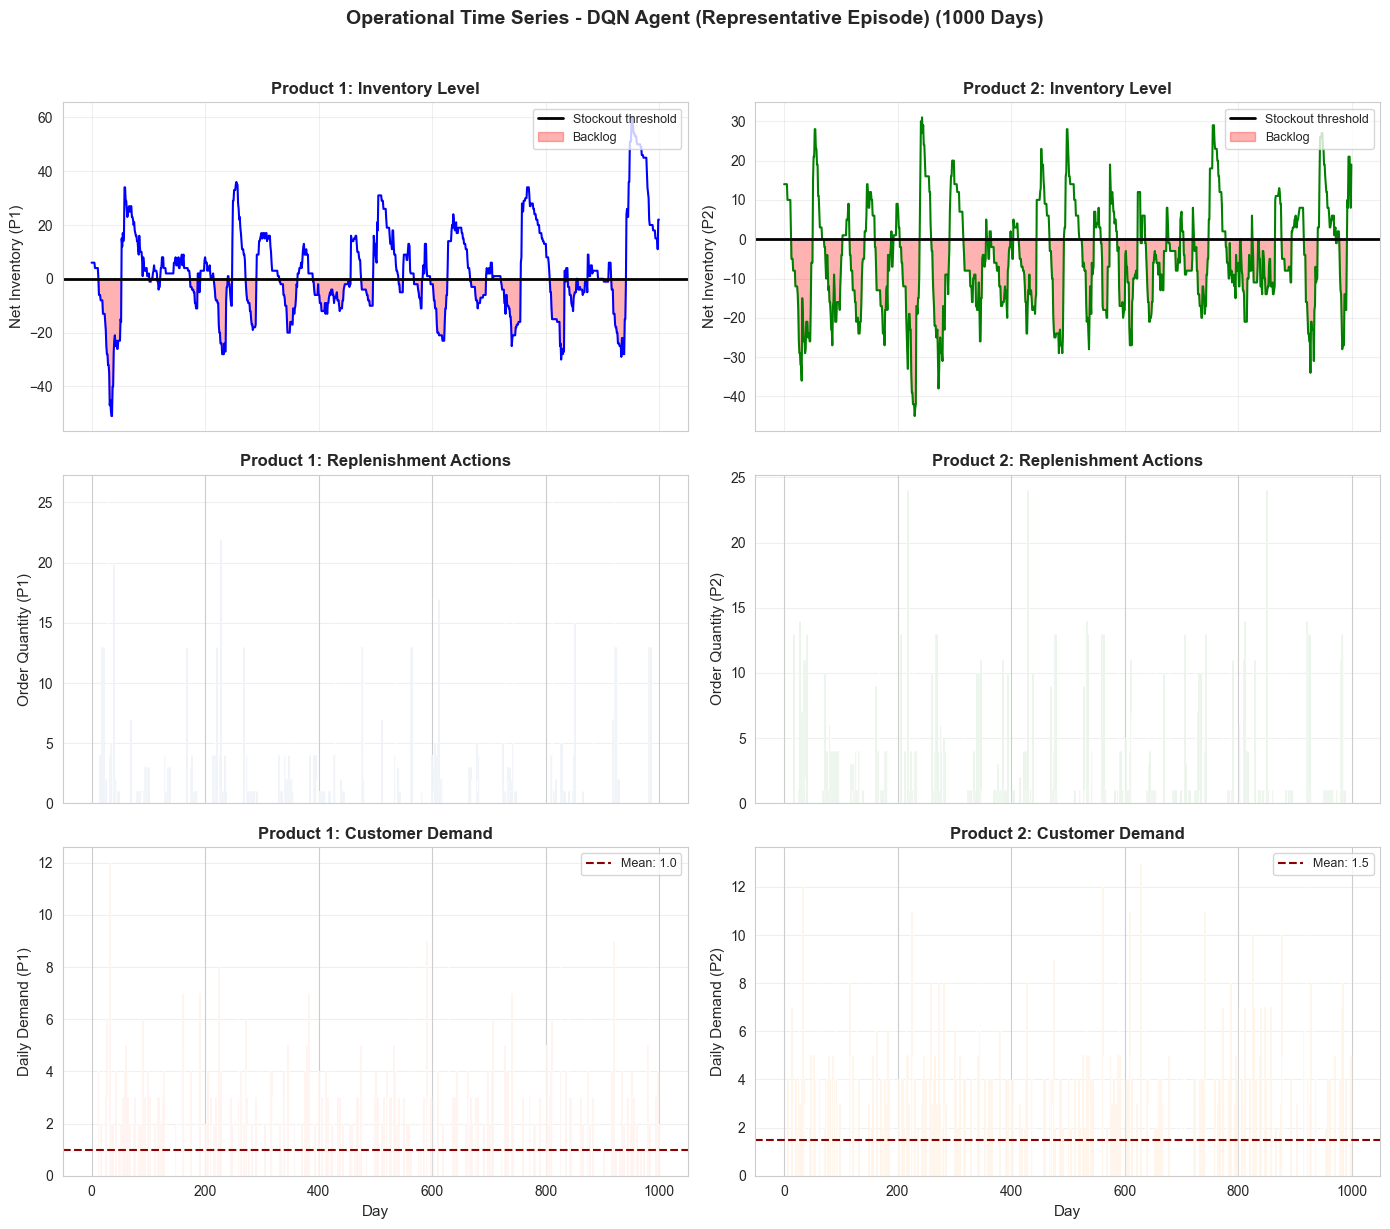

In [14]:

episode_avg_costs = [np.mean(ep['total_daily_cost']) for ep in test_episodes_dqn]
global_mean_cost = np.mean(episode_avg_costs)
representative_idx = np.argmin(np.abs(np.array(episode_avg_costs) - global_mean_cost))

print(f"📊 Representative episode: {representative_idx} (avg cost: {episode_avg_costs[representative_idx]:.2f}, global mean: {global_mean_cost:.2f})")

# Operational Time Series - Use the first episode
evaluation_plots.plot_operational_timeseries(
    episode_data=test_episodes_dqn[representative_idx],
    title="Operational Time Series - DQN Agent (Representative Episode)",
)

### 5. Inventory Distribution Histogram (Risk Profile)
Distribution of Net Inventory levels over all test episodes. Red = Backlog (I < 0), Green = On-Hand (I > 0).


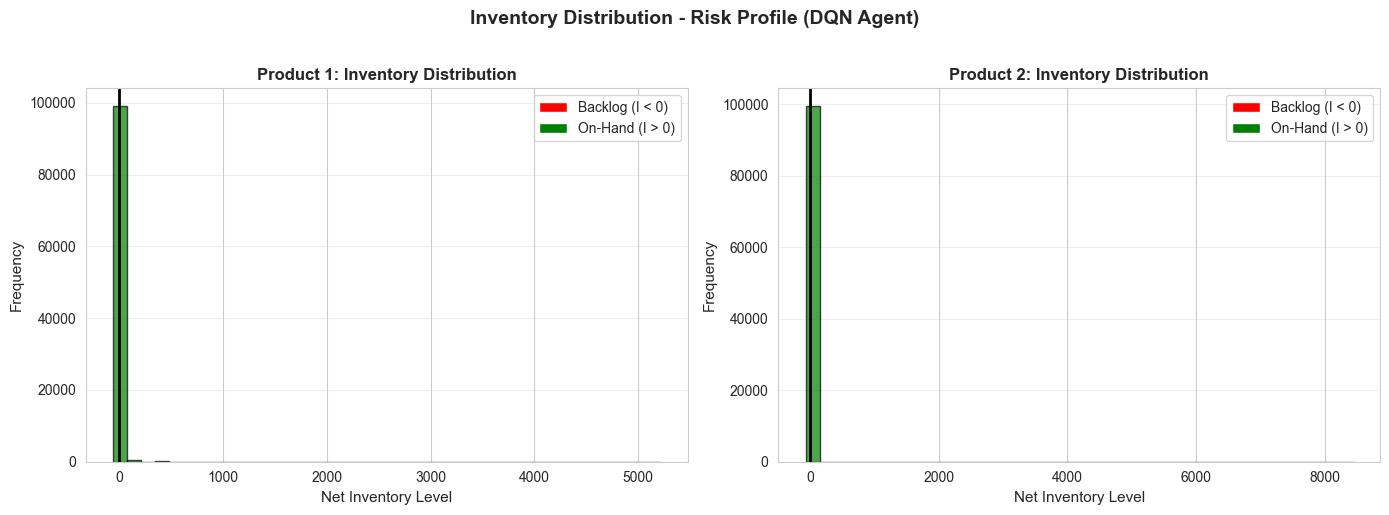

⚙️Service Level (% days without stockout):
  Product 1: 57.2%
  Product 2: 41.1%


In [18]:
# Inventory Distribution Histogram
evaluation_plots.plot_inventory_histogram(
    test_episodes=test_episodes_dqn,
    title="Inventory Distribution - Risk Profile (DQN Agent)",
)